In [422]:
import os
import math
import random

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader, TensorDataset, Dataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [423]:
# 1. Load UK Land Registry data
# source: https://www.kaggle.com/datasets/jakewright/house-price-data
csv_path = 'data/kaggle_london_house_price_data.csv'
df =pd.read_csv(csv_path)

print('shape:', df.shape)
df.head()

shape: (418201, 28)


,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,...,saleEstimate_upperPrice,saleEstimate_confidenceLevel,saleEstimate_ingestedAt,saleEstimate_valueChange.numericChange,saleEstimate_valueChange.percentageChange,saleEstimate_valueChange.saleDate,history_date,history_price,history_percentageChange,history_numericChange
0,"Flat 9, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,1.0,1.0,45.0,1.0,...,630000.0,HIGH,2024-10-07T13:26:59.894Z,244000.0,68.539326,2010-03-30,1995-01-02,830000,NaN,NaN
1,"Flat 6, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,NaN,NaN,NaN,NaN,...,660000.0,MEDIUM,2024-10-07T13:26:59.894Z,425000.0,242.857143,2000-05-26,1995-01-02,830000,NaN,NaN
2,"Flat 35, Octavia House, Medway Street, London,...",SW1P 2TA,England,SW1P,51.495505,-0.132379,2.0,2.0,71.0,1.0,...,834000.0,MEDIUM,2025-01-10T11:04:57.114Z,49000.0,6.901408,2019-09-04,1995-01-03,249950,NaN,NaN
3,"24 Chester Court, Lomond Grove, London, SE5 7HS",SE5 7HS,England,SE5,51.478185,-0.092201,1.0,1.0,64.0,1.0,...,407000.0,HIGH,2024-10-07T13:26:59.894Z,28000.0,7.777778,2024-01-25,1995-01-03,32000,NaN,NaN
4,"18 Alexandra Gardens, London, N10 3RL",N10 3RL,England,N10,51.588774,-0.139599,1.0,4.0,137.0,2.0,...,1324000.0,HIGH,2024-10-07T13:26:59.894Z,81000.0,6.864407,2022-12-14,1995-01-03,133000,NaN,NaN


### Explore data

In [392]:
df.describe()

,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,rentEstimate_lowerPrice,rentEstimate_currentPrice,rentEstimate_upperPrice,saleEstimate_lowerPrice,saleEstimate_currentPrice,saleEstimate_upperPrice,saleEstimate_valueChange.numericChange,saleEstimate_valueChange.percentageChange,history_price,history_percentageChange,history_numericChange
count,418201.000000,418201.000000,340270.000000,377665.000000,392991.000000,357701.000000,416460.000000,416460.000000,416460.000000,4.175610e+05,4.175610e+05,4.175610e+05,4.175610e+05,417561.000000,4.182010e+05,237982.000000,2.379820e+05
mean,51.507522,-0.101426,1.444265,2.474884,98.926543,1.282275,3299.054171,3639.487466,3980.117298,8.312692e+05,9.045188e+05,9.777633e+05,2.886077e+04,29.278605,6.395840e+05,105.877778,2.528741e+05
std,0.056171,0.086930,0.724478,1.160506,55.938911,0.574412,3168.625404,3487.801945,3808.508868,8.088434e+05,9.202917e+05,1.037913e+06,1.080893e+06,362.350731,1.327933e+06,338.849944,8.024032e+05
min,51.385708,-0.347055,1.000000,1.000000,10.000000,1.000000,300.000000,350.000000,400.000000,8.100000e+04,8.900000e+04,9.300000e+04,-1.053770e+08,-99.763196,1.000000e+04,-99.890110,-7.390000e+07
25%,51.464315,-0.155996,1.000000,2.000000,63.000000,1.000000,1800.000000,1950.000000,2100.000000,4.160000e+05,4.460000e+05,4.750000e+05,1.100000e+04,2.105263,2.280000e+05,17.833333,4.849500e+04
50%,51.501581,-0.108482,1.000000,2.000000,84.000000,1.000000,2350.000000,2600.000000,2850.000000,5.810000e+05,6.220000e+05,6.630000e+05,3.500000e+04,6.260870,4.000000e+05,52.857143,1.300000e+05
75%,51.548515,-0.043582,2.000000,3.000000,116.000000,1.000000,3550.000000,3950.000000,4300.000000,9.130000e+05,9.840000e+05,1.054000e+06,8.600000e+04,13.554987,6.650000e+05,114.285714,2.870000e+05
max,51.665823,0.139249,9.000000,9.000000,500.000000,9.000000,111500.000000,121200.000000,130900.000000,2.337600e+07,2.922000e+07,3.506400e+07,2.268100e+07,48860.000000,1.058000e+08,48800.770000,6.382000e+07


In [393]:
print(df.columns)

Index(['fullAddress', 'postcode', 'country', 'outcode', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms',
       'tenure', 'propertyType', 'currentEnergyRating',
       'rentEstimate_lowerPrice', 'rentEstimate_currentPrice',
       'rentEstimate_upperPrice', 'saleEstimate_lowerPrice',
       'saleEstimate_currentPrice', 'saleEstimate_upperPrice',
       'saleEstimate_confidenceLevel', 'saleEstimate_ingestedAt',
       'saleEstimate_valueChange.numericChange',
       'saleEstimate_valueChange.percentageChange',
       'saleEstimate_valueChange.saleDate', 'history_date', 'history_price',
       'history_percentageChange', 'history_numericChange'],
      dtype='object')


In [394]:
# notes on features:
# df.propertyType
# property type is an important categorical feature, but need to convert to correct type first
# rooms = bedrooms + livingrooms
# it makes mmore sense to combine these two features into one 'rooms' feature

In [ ]:
### convert to correct types
df['history_date'] = pd.to_datetime(df['history_date'])
df['history_price'] = df['history_price'].astype(float)

# remove 'bad' data
df = df.dropna(subset=['history_price','history_date'])
df = df.sort_values(by=['history_date'])

print('shape after cleaning:', df.shape)

shape after cleaning: (418201, 30)


In [411]:
## aggregate to monthly
df['month'] = df['history_date'].dt.to_period('M').dt.to_timestamp()

# rooms = bedrooms + livingRooms
df['rooms'] = pd.to_numeric(df['bedrooms'], errors='coerce').fillna(0) + pd.to_numeric(df['livingRooms'], errors='coerce').fillna(0)

numeric_feats= ['rooms', 'bathrooms', 'floorAreaSqM', 'latitude', 'longitude']

# ensure numeric
df[numeric_feats] = df[numeric_feats].apply(pd.to_numeric, errors='coerce')

# simplify propertyType -> flat vs house vs other
def map_property_type(pt):
    if isinstance(pt, str):
        s = pt.lower()
    else:
        return np.nan
    flat_terms = ['flat', 'maisonette', 'apartment', 'purpose built', 'studio']
    house_terms = ['house', 'detached', 'semi', 'terrace', 'terraced', 'bungalow']
    if any(t in s for t in flat_terms):
        return 'flat'
    if any(t in s for t in house_terms):
        return 'house'
    return 'other'

# df['property_type_simple'] = df['propertyType'].apply(map_property_type)
# ptype_dummies = pd.get_dummies(df['property_type_simple'], prefix='ptype')

# # outcode target-ish encoding: median history_price per outcode
# outcode_median = df.groupby('outcode')['history_price'].median()
# global_price_median = df['history_price'].median()
# df['outcode_price_median'] = df['outcode'].map(outcode_median).fillna(global_price_median)
# numeric_feats.append('outcode_price_median')

# df_ptype = pd.concat([df[["month"]], ptype_dummies], axis=1)
# monthly_type_counts= df_ptype.groupby('month').sum()
# monthly_type_props=monthly_type_counts.div(monthly_type_counts.sum(axis=1), axis=0)

# aggregate
monthly_data = df.groupby('month').agg({
    'history_price': 'median',
    'rooms': 'median',
    'bathrooms': 'median',
    'floorAreaSqM': 'median',
    # 'latitude': 'median',
    # 'longitude': 'median',
    # 'outcode_price_median': 'median'
}).reset_index()

# monthly_data = monthly_data.merge(monthly_type_props, on='month', how='left')

# compute price per sqm at monthly level
monthly_data['price_per_sqm'] = monthly_data['history_price'] / monthly_data['floorAreaSqM']
monthly_data['price_per_sqm'] = monthly_data['price_per_sqm'].replace([np.inf, -np.inf], np.nan)



### Training split

In [412]:
monthly_data = monthly_data.sort_values(by='month').reset_index(drop=True)

# fill feature columns (no target) to remove NaNs before scaling
feature_fill_cols = [col for col in monthly_data.columns if col not in ['month', 'history_price']]
monthly_data[feature_fill_cols] = monthly_data[feature_fill_cols].fillna(method='ffill')

# OLD target (log of history_price)
# monthly_data['log_price'] = np.log(monthly_data['history_price'])
# use price_per_sqm instead
monthly_data['price_per_sqm'] = monthly_data['price_per_sqm'].replace([np.inf, -np.inf], np.nan)
monthly_data['price_per_sqm'] = monthly_data['price_per_sqm'].fillna(method='ffill')
monthly_data['log_price_per_sqm'] = np.log(monthly_data['price_per_sqm'])

# OLD feature selection (included log_price)
# feature_cols = [ col for col in monthly_data.columns if col not in ['month', 'history_price', 'log_price']]
# exclude new target columns
# feature_cols = [ col for col in monthly_data.columns if col not in ['month', 'history_price', 'price_per_sqm', 'log_price_per_sqm'] ]
feature_cols = [ col for col in monthly_data.columns if col not in ['month', 'history_price', 'price_per_sqm', 'log_price_per_sqm'] ]

X_all = monthly_data[feature_cols].values
# OLD target
# y_all = monthly_data['log_price'].values.reshape(-1,1)
y_all = monthly_data['log_price_per_sqm'].values.reshape(-1,1)

n_samples = len(monthly_data)
train_end = int(n_samples * 0.8)
val_end = int(n_samples * 0.9)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

print('Train shape:', X_train.shape, y_train.shape)
print('Val shape:', X_val.shape, y_val.shape)
print('Test shape:', X_test.shape, y_test.shape)

# scale features
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)



Train shape: (285, 3) (285, 1)
Val shape: (36, 3) (36, 1)
Test shape: (36, 3) (36, 1)


/var/folders/6h/cvy0pnyn3h188rs50099dz1m0000gp/T/ipykernel_33667/1080888477.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data[feature_fill_cols] = monthly_data[feature_fill_cols].fillna(method='ffill')
/var/folders/6h/cvy0pnyn3h188rs50099dz1m0000gp/T/ipykernel_33667/1080888477.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['price_per_sqm'] = monthly_data['price_per_sqm'].fillna(method='ffill')


In [413]:
# quick data diagnostics
print('NaNs after fill:')
print(monthly_data.isna().sum())

print('Feature summary (log price + inputs):')
print(monthly_data[[*feature_cols, 'history_price']].describe().T[['mean','std','min','max']])

print('Unique counts per feature:')
print(monthly_data[feature_cols].nunique())


NaNs after fill:
month                0
history_price        0
rooms                0
bathrooms            0
floorAreaSqM         0
price_per_sqm        0
log_price_per_sqm    0
dtype: int64
Feature summary (log price + inputs):
                       mean            std      min       max
rooms               3.00000       0.000000      3.0       3.0
bathrooms           1.00000       0.000000      1.0       1.0
floorAreaSqM       83.60084       3.844729     75.0      95.0
history_price  338619.47479  165525.471476  75750.0  600000.0
Unique counts per feature:
rooms            1
bathrooms        1
floorAreaSqM    32
dtype: int64


In [414]:
# naive baseline: predict last available log price
def naive_last_value_metrics(y_scaled):
    y = y_scaled.flatten()
    if len(y) < 2:
        return float('nan'), float('nan')
    diff = y[1:] - y[:-1]
    mse = np.mean(diff ** 2)
    mae = np.mean(np.abs(diff))
    return mse, mae

train_naive_mse, train_naive_mae = naive_last_value_metrics(y_train_scaled)
val_naive_mse, val_naive_mae = naive_last_value_metrics(y_val_scaled)
test_naive_mse, test_naive_mae = naive_last_value_metrics(y_test_scaled)

print(f'Naive last-value baseline (scaled log price) - Train MSE: {train_naive_mse:.4f}, MAE: {train_naive_mae:.4f}')
print(f'Naive last-value baseline (scaled log price) - Val MSE: {val_naive_mse:.4f}, MAE: {val_naive_mae:.4f}')
print(f'Naive last-value baseline (scaled log price) - Test MSE: {test_naive_mse:.4f}, MAE: {test_naive_mae:.4f}')


Naive last-value baseline (scaled log price) - Train MSE: 0.0100, MAE: 0.0790
Naive last-value baseline (scaled log price) - Val MSE: 0.0095, MAE: 0.0800
Naive last-value baseline (scaled log price) - Test MSE: 0.0022, MAE: 0.0342


In [415]:
# sliding window dataset
SEQ_LENGTH = 12  # e.g., use past 12 months to predict next month

def create_sequences(X, y, seq_length):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - seq_length):
        seq_X = X[i:i + seq_length]
        seq_y = y[i + seq_length]
        sequences_X.append(seq_X)
        sequences_y.append(seq_y)
    return np.array(sequences_X), np.array(sequences_y)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LENGTH)
print('Seq Train shape:', X_train_seq.shape, y_train_seq.shape)
print('Seq Val shape:', X_val_seq.shape, y_val_seq.shape)
print('Seq Test shape:', X_test_seq.shape, y_test_seq.shape)


Seq Train shape: (273, 12, 3) (273, 1)
Seq Val shape: (24, 12, 3) (24, 1)
Seq Test shape: (24, 12, 3) (24, 1)


In [416]:
BATCH_SIZE = 16

class HousePriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

train_dataset = HousePriceDataset(X_train_seq, y_train_seq)
val_dataset = HousePriceDataset(X_val_seq, y_val_seq)
test_dataset = HousePriceDataset(X_test_seq, y_test_seq)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print('DataLoader created with batch size:', BATCH_SIZE)

DataLoader created with batch size: 16


In [417]:
# model

input_size = X_train_seq.shape[-1]

class HousePricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers>1 else 0.0)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)
        
        return out

model= HousePricePredictor(input_size=input_size).to(device)
model

HousePricePredictor(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [418]:
from torch.optim import Adam

mse_loss_fn = nn.MSELoss()
mae_loss_fn = nn.L1Loss()
optimiser = Adam(model.parameters(), lr=0.001)

### Training loop
def train_epoch(model, data_loader, loss_fn, optimiser, mse_loss_fn, mae_loss_fn, device):
    model.train()
    running_mse, running_mae = 0.0, 0.0
    n_batches = 0

    for X_batch, y_batch in data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimiser.zero_grad()
        y_pred = model(X_batch)

        mse= mse_loss_fn(y_pred, y_batch)
        mae= mae_loss_fn(y_pred, y_batch)

        mse.backward()
        optimiser.step()

        running_mse += mse.item()
        running_mae += mae.item()
        n_batches += 1
        
    return running_mse / n_batches, running_mae / n_batches

@torch.no_grad()
def eval_model(model, data_loader, mse_loss_fn, mae_loss_fn, device):
    model.eval()
    running_mse, running_mae = 0.0, 0.0
    n_batches = 0

    for X_batch, y_batch in data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        mse= mse_loss_fn(y_pred, y_batch)
        mae= mae_loss_fn(y_pred, y_batch)

        running_mse += mse.item()
        running_mae += mae.item()
        n_batches += 1
        
    return running_mse / n_batches, running_mae / n_batches

In [419]:
EPOCHS = 30

train_mse_history, train_mae_history = [], []
val_mse_history, val_mae_history = [], []

for epoch in range(1, EPOCHS + 1):
    train_mse, train_mae = train_epoch(model, train_loader, mse_loss_fn, optimiser, mse_loss_fn, mae_loss_fn, device)
    val_mse, val_mae = eval_model(model, val_loader, mse_loss_fn, mae_loss_fn, device)

    train_mse_history.append(train_mse)
    train_mae_history.append(train_mae)
    val_mse_history.append(val_mse)
    val_mae_history.append(val_mae)

    print(f'Epoch {epoch}/{EPOCHS} - Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f} | Val MSE: {val_mse:.4f}, MAE: {val_mae:.4f}')

Epoch 1/30 - Train MSE: 0.8646, MAE: 0.7750 | Val MSE: 1.8178, MAE: 1.3413
Epoch 2/30 - Train MSE: 0.4179, MAE: 0.5500 | Val MSE: 6.0625, MAE: 2.4182
Epoch 3/30 - Train MSE: 0.3652, MAE: 0.4941 | Val MSE: 4.6839, MAE: 2.0719
Epoch 4/30 - Train MSE: 0.3372, MAE: 0.4939 | Val MSE: 5.2419, MAE: 2.1966
Epoch 5/30 - Train MSE: 0.2805, MAE: 0.4359 | Val MSE: 5.7591, MAE: 2.3130
Epoch 6/30 - Train MSE: 0.2721, MAE: 0.4345 | Val MSE: 4.9629, MAE: 2.1481
Epoch 7/30 - Train MSE: 0.2952, MAE: 0.4648 | Val MSE: 4.9555, MAE: 2.1445
Epoch 8/30 - Train MSE: 0.2837, MAE: 0.4561 | Val MSE: 5.6322, MAE: 2.2760
Epoch 9/30 - Train MSE: 0.2686, MAE: 0.4367 | Val MSE: 5.2698, MAE: 2.2062
Epoch 10/30 - Train MSE: 0.2610, MAE: 0.4137 | Val MSE: 5.2173, MAE: 2.2038
Epoch 11/30 - Train MSE: 0.2604, MAE: 0.4173 | Val MSE: 5.0795, MAE: 2.1722
Epoch 12/30 - Train MSE: 0.2703, MAE: 0.4373 | Val MSE: 5.4065, MAE: 2.2232
Epoch 13/30 - Train MSE: 0.2877, MAE: 0.4450 | Val MSE: 5.5101, MAE: 2.2526
Epoch 14/30 - Train M

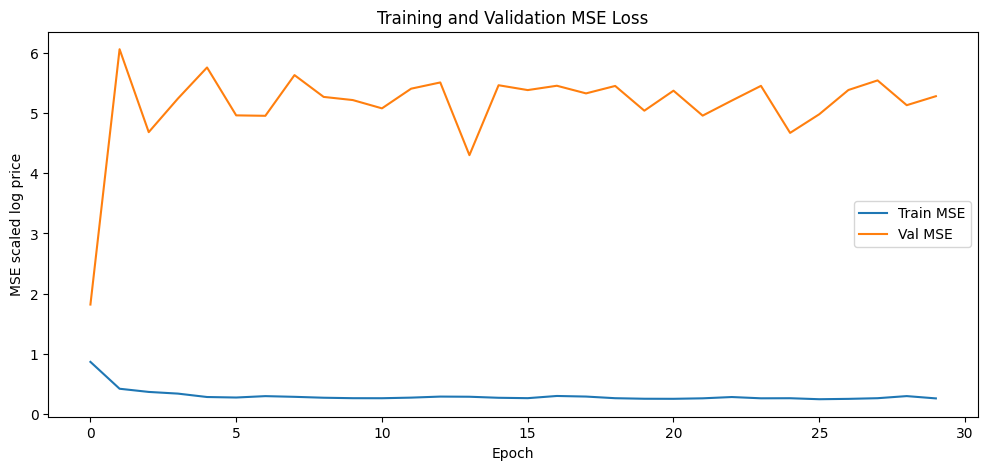

In [420]:
# plot

plt.figure(figsize=(12, 5))
plt.plot(train_mse_history, label='Train MSE')
plt.plot(val_mse_history, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE scaled log price')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.tight_layout
plt.show()

In [421]:
# evaluate on test set
test_mse, test_mae = eval_model(model, test_loader, mse_loss_fn, mae_loss_fn, device)
print(f'Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}')

Test MSE: 5.6007, MAE: 2.3259


In [407]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(X_batch)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)
# inverse scale
all_preds_inv = y_scaler.inverse_transform(all_preds)
all_targets_inv = y_scaler.inverse_transform(all_targets)
# inverse log (back to gbp prices)
all_preds_final = np.exp(all_preds_inv)
all_targets_final = np.exp(all_targets_inv)


24 24 24


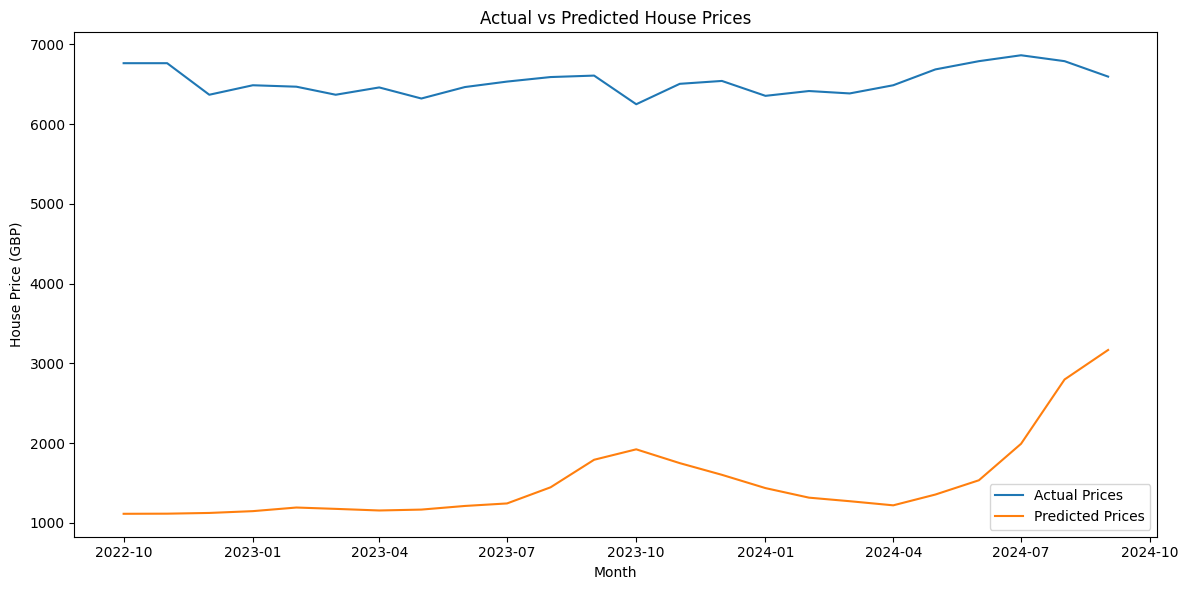

In [408]:
n_preds = len(all_preds_final)

test_months_for_preds = monthly_data['month'].values[-n_preds:]

print(len(test_months_for_preds), len(all_preds_final), len(all_targets_final))

plt.figure(figsize=(12, 6))
plt.plot(test_months_for_preds, all_targets_final, label='Actual Prices')
plt.plot(test_months_for_preds, all_preds_final, label='Predicted Prices')
plt.xlabel('Month')
plt.ylabel('House Price (GBP)')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.tight_layout()
plt.show()

In [409]:
print('test mse (scaled)', test_mse)
print('test mae (scaled)', test_mae)

print('first 5 predictions vs actuals:', all_targets_inv[:5], all_preds_inv[:5])

test mse (scaled) 6.249736547470093
test mae (scaled) 2.4500274658203125
first 5 predictions vs actuals: [[8.819474]
 [8.819474]
 [8.759205]
 [8.777724]
 [8.774931]] [[7.015675]
 [7.017093]
 [7.025224]
 [7.045101]
 [7.083868]]
